## To Do List
- Fix non running horses
- Collect races for the day
- Fully automate

In [1]:
from bs4 import BeautifulSoup
import datetime
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import scipy as sp
from scipy.optimize import curve_fit
import time

In [2]:
HEADERS = {
    'Accept' : 'application/json',
    'Content-Type' : 'application/json',
    'Referer' : 'https://www.racingtv.com/',
    'sec-ch-ua' : '"Not;A=Brand";v="99", "Google Chrome";v="139", "Chromium";v="139"',
    'sec-ch-ua-mobile' : '?0',
    'sec-ch-ua-platform' : '"Windows"',
    'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/139.0.0.0 Safari/537.36',
    'x-requested-with' : 'racingtv-web/5.3.0'
}

In [3]:
def one_keyword_data(metric_data, keyword):
    extract_list = []
    for data in metric_data:
        try:
            extract_list.append(data[keyword])
        except:
            extract_list.append('N/A')
    return extract_list

def three_keyword_data(metric_data, keyword1, keyword2, keyword3):
    extract_list = []
    for data in metric_data:
        try:
            extract_list.append(data[keyword1][keyword2][keyword3])
        except:
            extract_list.append('N/A')
    return extract_list

In [4]:
def collect_race_data(data_response, race_response, delay = 1):
    if data_response.status_code == 200:
        try:
            metric_data = data_response.json()['horses']
        except:
            print('Could not find "horses" in the json')
            return 'No horse data'
    else:
        print('Error code {:d}'.format(response.status_code))
        print('Problem url is: {:s}'.format(data_url))
        return
            
    if race_response.status_code == 200:
        try:
            race_data = race_response.json()['race']
        except:
            print('Could not find "race" in the json')
            print('Problem url is: {:s}'.format(race_url))
            print('Aborting data collection')
            return
    else:
        print('Error code {:d}'.format(response.status_code))
        print('Problem url is: {:s}'.format(data_url))
        return
        
    num_horses = len(metric_data)

    horse_info = {
        'Horse' : one_keyword_data(metric_data, 'horse_name'),
        'Position' : one_keyword_data(metric_data, 'finish_position'),
        'Finishing Speed (%)' : three_keyword_data(metric_data, 'metrics', 'fsp', 'value'),
        'Finishing Speed Rank' : three_keyword_data(metric_data, 'metrics', 'fsp', 'rank'),
        'Finishing Speed Average' : three_keyword_data(metric_data, 'metrics', 'fsp', 'average'),
        'Finishing Speed Percentage' : three_keyword_data(metric_data, 'metrics', 'fsp', 'percentage'),
        # 'Accelearion Value (s)' : three_keyword_data(metric_data, 'metrics', 'acceleration', 'value'),
        # 'Accelearion Rank' : three_keyword_data(metric_data, 'metrics', 'acceleration', 'rank'),
        # 'Accelearion Average' : three_keyword_data(metric_data, 'metrics', 'acceleration', 'average'),
        # 'Accelearion Percentage' : three_keyword_data(metric_data, 'metrics', 'acceleration', 'percentage'),
        # 'Stride Length Value (m)' : three_keyword_data(metric_data, 'metrics', 'stride_length', 'value'),
        # 'Stride Length Rank' : three_keyword_data(metric_data, 'metrics', 'stride_length', 'rank'),
        # 'Stride Length Average' : three_keyword_data(metric_data, 'metrics', 'stride_length', 'average'),
        # 'Stride Length Percentage' : three_keyword_data(metric_data, 'metrics', 'stride_length', 'percentage'),
        'Top Speed Value (mph)' : three_keyword_data(metric_data, 'metrics', 'top_speed', 'value'),
        'Top Speed Rank' : three_keyword_data(metric_data, 'metrics', 'top_speed', 'rank'),
        'Top Speed Average' : three_keyword_data(metric_data, 'metrics', 'top_speed', 'average'),
        'Top Speed Percentage' : three_keyword_data(metric_data, 'metrics', 'top_speed', 'percentage'),
        'Race Id' : [race_data['id']] * num_horses,
        'Race Type' : [race_data['race_type']] * num_horses,
        'Location' : [race_data['meeting']['track']['name']] * num_horses,
        'Trainer' : one_keyword_data(race_data['runners'], 'trainer_name'),
        'Jockey' : one_keyword_data(race_data['runners'], 'jockey_name'),
        'Owner' : one_keyword_data(race_data['runners'], 'owner_name'),
        'Age' : one_keyword_data(race_data['runners'], 'age'),
    }

    return horse_info

In [5]:
def race_times(date, delay = 1, DEBUG = False):
    # Only looking at UK and Ireland tracks
    with open('track_names.json', 'r') as fp:
        approved_tracks = json.load(fp)['Track Names']
    
    time.sleep(delay)
    response = requests.get('https://api.racingtv.com/racing/results/list/{:s}?'.format(date), headers = HEADERS)
    time_dict = {}
    if response.status_code == 200:
        try:
            race_meetings = response.json()['meetings']
        except:
            print('Could not find "meetings" in the json')
            print('Problem url is: https://api.racingtv.com/racing/results/list/{:s}?'.format(date))
            print('Aborting data collection')
            return
    for data1 in race_meetings:
        track_name = data1['track']['name']
        if track_name in approved_tracks:
            time_data = []
            for data2 in data1['completed_races']:
                timestamp = pd.to_datetime(data2['start_time_scheduled'])
                time_data.append(str(timestamp.time())[0:5].replace(':', ''))
            time_dict[track_name] = time_data
        elif DEBUG:
            # Write to text file
            with open('race_times_debug.txt', 'a') as fp:
                fp.write('{:s} is not an approved track\n'.format(track_name))

    return time_dict

In [6]:
def collect_all_race_times(start_date, end_date, delay = 1, write_out = False, 
                           file_name = 'race_times{:s}'.format(str(pd.Timestamp.today().date())), 
                           DEBUG = False):
    date_range = pd.date_range(start = start_date, end = end_date, freq = 'D')
    time_data = {}
    for date in date_range:
        date_str = str(date.date())
        time_data.update({date_str : race_times(date_str, delay, DEBUG)})
        if DEBUG:
            with open('race_times_debug.txt', 'a') as fp:
                fp.write('Collected race times for {:s}'.format(date_str))

    if write_out:
        with open(file_name, 'w') as fp:
            json.dump(time_data, fp)
        
    return time_data

In [7]:
def track_day_data(date, times, trackname, delay = 1, DEBUG = False):
    # Changing name of edge cases
    if trackname.lower() == 'lingfield':
        trackname = trackname + '-Park'
    # Replace space with - to make urls work
    trackname = trackname.replace(' ', '-')

    print(trackname)
    
    data = {}
    for race_time in times:
        data_url = 'https://api.racingtv.com/racing/iq-results/{:s}/{:s}/{:s}/comparison?'.format(date, trackname.lower(), race_time)
        race_url = 'https://api.racingtv.com/racing/results/{:s}/{:s}/{:s}?'.format(date, trackname.lower(), race_time)
        time.sleep(delay)
        race_response = requests.get(race_url, headers = HEADERS)
        if race_response.json()['race']['status']['state'] != 'abandoned':
            time.sleep(delay)
            data_response = requests.get(data_url, headers = HEADERS)
            collected_race_data = collect_race_data(data_response, race_response, delay)
            # If there is horse data, update data
            if collected_race_data != 'No horse data':
                data.update({race_time[:2] + ':' + race_time[2:] : collected_race_data})
            elif DEBUG:
                print('{:s}/{:s}/{:s} has no horse data'.format(date, trackname.lower(), race_time))
        elif DEBUG:
            print('{:s}/{:s}/{:s} was abandoned'.format(date, trackname.lower(), race_time))

        print('Collected race data for {:s} at {:s}'.format(trackname, race_time[:2] + ':' + race_time[2:]))
        
    return data

In [8]:
def collect_all_day_data(day_races, date, delay = 1, DEBUG = False):
    # For checking progress
    progress = 0
    count = len(day_races.values())
        
    data = {}
    for trackname, times in day_races.items():
        progress += 1
        track_dict = track_day_data(date, times, trackname, delay, DEBUG)
        # If track_dict is not empty, update data
        if track_dict:
            data.update({trackname : track_dict})
        print('Progress: {:d}/{:d}'.format(progress, count))
    return data

In [9]:
def track_names(delay = 1, write_out = False):
    uk_url = 'https://api.racingtv.com//racing/tracks/uk?'
    uk_response = requests.get(uk_url, headers = HEADERS)
    if uk_response.status_code != 200:
        print('Problem with the url: {:s}'.format(uk_url))
        return
    
    time.sleep(delay)
    
    ire_url = 'https://api.racingtv.com//racing/tracks/ire?'
    ire_response = requests.get(ire_url, headers = HEADERS)
    if ire_response.status_code != 200:
        print('Problem with the url: {:s}'.format(ire_url))
        return

    track_list = []

    for data in uk_response.json()['tracks']:
        track_list.append(data['name'])
    for data in ire_response.json()['tracks']:
        track_list.append(data['name'])

    #Writing track names to a json file
    if write_out == True:
        with open('track_names.json', 'w') as fp:
            json.dump({'Track Names' : track_list}, fp)
        
    return track_list

In [10]:
def collection_of_race_data(start_date, end_date, delay = 1,
                            write_out = True,
                            return_data = True,
                            DEBUG = False):
    
    try:
        with open('race_times.json', 'r') as fp:
            all_race_times = json.load(fp)
    except:
        print('Collecting track times')
        all_race_times = collect_all_race_times(start_date, end_date, delay, write_out,
                                                file_name = 'race_times'.format(start_date, end_date),
                                                DEBUG = False)

    data_dict = {}
    date_range = pd.date_range(start_date, end_date, freq = 'D')

    for date in date_range:
        date_str = str(date.date())
        print('Collecting data for {:s}'.format(date_str))
        all_day_data = collect_all_day_data(all_race_times[date_str], date_str, delay, DEBUG = False)
        # If all_day_data is not empty, update data_dict
        if all_day_data:
            data_dict.update({date_str : all_day_data})

    # Below conditions need some fixing
    
    if write_out:
        with open('historical_horse_data_{:s}_{:s}.json'.format(start_date, end_date), 'w') as fp:
            json.dump(data_dict, fp)

    # Below does match write_out bool
    
    if return_data:
        print('Data saved to: historical_horse_data.json')
        return data_dict
    else:
        return 'Data saved to: historical_horse_data.json'

In [11]:
def unpack_json_to_df(json_file):
    with open(json_file, 'r') as fp:
        race_data = json.load(fp)

    simple_list = []
    for date in race_data.keys():
        for track in race_data[date].keys():
            for time in race_data[date][track].keys():
                for i in range(len(race_data[date][track][time]['Horse'])):
                    useful_data = race_data[date][track][time]


                    #temporary fix
                    if date == '2025-05-24' and track == 'Windsor' and useful_data['Horse'][i] == 'Dubai Time':
                        print('Dubai Time found')
                        continue
                    if date == '2025-08-04' and track == 'Windsor' and useful_data['Horse'][i] == 'Piscean Star':
                        print('Piscean Star')
                        continue

                    else:
                        # print('{:s}{:s}{:s}'.format(date, track, time))
                        simple_list.append({'Date' : date,
                                            'Track' : track,
                                            'Time' : time,
                                            'Horse' : useful_data['Horse'][i],
                                            'Position' : useful_data['Position'][i],
                                            'Finishing Speed (%)' : useful_data['Finishing Speed (%)'][i],
                                            'Top Speed Value (mph)' : useful_data['Top Speed Value (mph)'][i],
                                            'Race Id' : useful_data['Race Id'][i],
                                            'Race Type' : useful_data['Race Type'][i],
                                            'Trainer' : useful_data['Trainer'][i],
                                            'Jockey' : useful_data['Jockey'][i],
                                            'Owner' : useful_data['Owner'][i],
                                            'Age' : useful_data['Age'][i],})

    return pd.json_normalize(simple_list).set_index('Date')

In [12]:
def finish_condition(df, race_id):
    # Select horse in a race which have a finishing speed above the median
    filtered_speed = df[(df['Race Id'] == race_id) & (df['Finishing Speed (%)'] >= df[df['Race Id'] == race_id][['Finishing Speed (%)']].quantile(q = 0.5).iloc[0])]['Finishing Speed (%)']

    # Find the mean and standard deviation of these finishing speeds
    mean = filtered_speed.mean()
    std = filtered_speed.std()

    return [mean, std]

In [13]:
def collect_basic_data(data_response, race_response, delay = 1):
    if data_response.status_code == 200:
        try:
            metric_data = data_response.json()['horses']
        except:
            print('Could not find "horses" in the json')
            return 'No horse data'
    else:
        print('Error code {:d}'.format(response.status_code))
        print('Problem url is: {:s}'.format(data_url))
        return
            
    if race_response.status_code == 200:
        try:
            race_data = race_response.json()['race']
        except:
            print('Could not find "race" in the json')
            print('Problem url is: {:s}'.format(race_url))
            print('Aborting data collection')
            return
    else:
        print('Error code {:d}'.format(response.status_code))
        print('Problem url is: {:s}'.format(data_url))
        return
        
    num_horses = len(metric_data)

    horse_info = {
        'Horse' : one_keyword_data(metric_data, 'horse_name'),
        'Race Id' : [race_data['id']] * num_horses,
        'Race Type' : [race_data['race_type']] * num_horses,
        'Location' : [race_data['meeting']['track']['name']] * num_horses,
    }

    return horse_info

In [14]:
def update_race_data(delay = 1):
    # Loading in historical data
    with open('historical_horse_data.json', 'r') as fp:
        historical_data = json.load(fp)
    # Loading in historical race times
    with open('race_times.json', 'r') as fp:
        historical_race_times = json.load(fp)
    
    # Last date in historical data
    last_date = pd.Timestamp(list(historical_data.keys())[-1])
    # Start one day after last date
    start_date = last_date + pd.Timedelta(days = 1)
    start_date_str = str(start_date.date())
    # End two days before current date (data from yesterday isn't always available on the website)
    end_date = pd.Timestamp.today() - pd.Timedelta(days = 2)
    end_date_str = str(end_date.date())

    if start_date <= end_date:
        # Collecting race times between start_date and end_date
        new_race_times = collect_all_race_times(start_date, end_date, delay, write_out = False)
        
        # Update race times data and json file
        historical_race_times.update(new_race_times)
        with open('race_times.json', 'w') as fp:
            json.dump(historical_race_times, fp)

        # Collecting race data between start_date and end_date
        new_data = collection_of_race_data(start_date, end_date, delay, write_out = False)
        
        # Update race data and json file
        historical_data.update(new_data)
        with open('historical_horse_data.json', 'w') as fp:
            json.dump(historical_data, fp)
    else:
        return 'Date is already up to date.'

In [15]:
update_race_data(delay = 0.1)

Chelmsford-City
Collected race data for Chelmsford-City at 17:30
Collected race data for Chelmsford-City at 18:00
Collected race data for Chelmsford-City at 18:30
Collected race data for Chelmsford-City at 19:00
Collected race data for Chelmsford-City at 19:30
Collected race data for Chelmsford-City at 20:00
Collected race data for Chelmsford-City at 20:30
Collected race data for Chelmsford-City at 21:00
Progress: 1/7
Lingfield-Park
Collected race data for Lingfield-Park at 14:00
Collected race data for Lingfield-Park at 14:35
Collected race data for Lingfield-Park at 15:10
Collected race data for Lingfield-Park at 15:45
Collected race data for Lingfield-Park at 16:20
Collected race data for Lingfield-Park at 16:55
Progress: 2/7
Newcastle
Collected race data for Newcastle at 17:45
Collected race data for Newcastle at 18:15
Collected race data for Newcastle at 18:45
Collected race data for Newcastle at 19:15
Collected race data for Newcastle at 19:45
Collected race data for Newcastle at

In [16]:
today_races = pd.read_csv('./Horse Data/racecards.csv',
                          index_col = 'runner_name')

today_races.index.names = ['Horse']

In [17]:
horse_df = unpack_json_to_df('historical_horse_data.json')

Dubai Time found
Piscean Star


In [18]:
# horse_df = pd.read_csv('./historical_horse_data_18-08-2025.csv')

In [19]:
cleaned_df = horse_df.dropna(subset=['Position'])
cleaned_df = cleaned_df.replace('N/A', np.nan)
cleaned_df[['Finishing Speed (%)', 'Top Speed Value (mph)']] = cleaned_df[['Finishing Speed (%)', 'Top Speed Value (mph)']].astype(float)

## Different fast finish conditions

In [20]:
high_condition_dict = {}
id_list = cleaned_df['Race Id'].unique().tolist()
for race_id in id_list:
    condition = finish_condition(cleaned_df, race_id)
    
    # Update dictionary with {race_id, mean + std}
    high_condition_dict.update({race_id : condition[0] + condition[1]})

In [21]:
med_condition_dict = {}
id_list = cleaned_df['Race Id'].unique().tolist()
for race_id in id_list:
    condition = finish_condition(cleaned_df, race_id)
    
    # Update dictionary with {race_id, mean + 0.8 * std}
    med_condition_dict.update({race_id : condition[0] + 0.8 * condition[1]})

In [22]:
low_condition_dict = {}
id_list = cleaned_df['Race Id'].unique().tolist()
for race_id in id_list:
    condition = finish_condition(cleaned_df, race_id)
    
    # Update dictionary with {race_id, mean + 0.5 * std}
    low_condition_dict.update({race_id : condition[0] + 0.5 * condition[1]})

In [23]:
high_fast_list = []
speed_list = cleaned_df['Finishing Speed (%)'].tolist()
id_list = cleaned_df['Race Id'].tolist()

for i in range(len(speed_list)):
    condition = speed_list[i] >= high_condition_dict[id_list[i]]
    if condition:
        high_fast_list.append(speed_list[i] >= high_condition_dict[id_list[i]])
    else:
        high_fast_list.append(np.nan)

In [24]:
med_fast_list = []

for i in range(len(speed_list)):
    condition = speed_list[i] >= med_condition_dict[id_list[i]]
    if condition:
        med_fast_list.append(speed_list[i] >= med_condition_dict[id_list[i]])
    else:
        med_fast_list.append(np.nan)

In [25]:
low_fast_list = []

for i in range(len(speed_list)):
    condition = speed_list[i] >= low_condition_dict[id_list[i]]
    if condition:
        low_fast_list.append(speed_list[i] >= low_condition_dict[id_list[i]])
    else:
        low_fast_list.append(np.nan)

In [26]:
cleaned_df.insert(0, 'Low Fast Finish' , low_fast_list)
cleaned_df.insert(0, 'Med Fast Finish' , med_fast_list)
cleaned_df.insert(0, 'High Fast Finish' , high_fast_list)

In [27]:
grouped_df = cleaned_df.groupby([cleaned_df['Horse']]).agg(
    **{
        # 'Best Finish (%)' : pd.NamedAgg(column = 'Finishing Speed (%)', aggfunc = 'max'),
        # 'Mean Finish (%)' : pd.NamedAgg(column = 'Finishing Speed (%)', aggfunc = 'mean'),
        # 'Worst Finish (%)' : pd.NamedAgg(column = 'Finishing Speed (%)', aggfunc = 'min'),
        # 'Std Finish (%)' : pd.NamedAgg(column = 'Finishing Speed (%)', aggfunc = 'std'),
        # 'Median Finish (%)' : pd.NamedAgg(column = 'Finishing Speed (%)', aggfunc = 'median'),
        'Best Speed (mph)' : pd.NamedAgg(column = 'Top Speed Value (mph)', aggfunc = 'max'),
        'Best Pos' : pd.NamedAgg(column = 'Position', aggfunc = 'min'),
        'Mean Pos' : pd.NamedAgg(column = 'Position', aggfunc = 'mean'),
        'Worst Pos' : pd.NamedAgg(column = 'Position', aggfunc = 'max'),
        'Std Pos' : pd.NamedAgg(column = 'Position', aggfunc = 'std'),
        'High Fast Finishes' : pd.NamedAgg(column = 'High Fast Finish', aggfunc = 'count'),
        'Med Fast Finishes' : pd.NamedAgg(column = 'Med Fast Finish', aggfunc = 'count'),
        'Low Fast Finishes' : pd.NamedAgg(column = 'Low Fast Finish', aggfunc = 'count'),
        'Num Races' : pd.NamedAgg(column = 'Position', aggfunc = 'count'), # Number of non-null position values (we have removed all null values)
    }
)

grouped_df['High Fast Races (%)'] = grouped_df['High Fast Finishes'] / grouped_df['Num Races']
grouped_df['Med Fast Races (%)'] = grouped_df['Med Fast Finishes'] / grouped_df['Num Races']
grouped_df['Low Fast Races (%)'] = grouped_df['Low Fast Finishes'] / grouped_df['Num Races']

In [28]:
grouped_df = grouped_df[['High Fast Races (%)', 'Med Fast Races (%)', 'Low Fast Races (%)', 'Best Speed (mph)',
                         'Best Pos', 'Mean Pos', 'Worst Pos', 'Std Pos', 'High Fast Finishes', 'Med Fast Finishes',
                         'Low Fast Finishes', 'Num Races']]

In [29]:
# grouped_df.loc[['Sir David', 'Raammee', 'Young Lucy', 'So Chic', 'Principality', 'You Are Everything']]

In [30]:
# horse_df[horse_df['Race Id'] == 608367]

In [31]:
today_races = today_races[['race_id', 'off_time', 'course_name', 'tips_count']]

today_races = today_races.join(grouped_df)

today_races = today_races.reset_index().set_index('off_time')
today_races = today_races[['course_name', 'Horse', 'High Fast Races (%)', 'Med Fast Races (%)', 'Low Fast Races (%)',
                           'Best Speed (mph)', 'Best Pos', 'Mean Pos', 'Worst Pos', 'Std Pos',
#                           'High Fast Finishes', 'Med Fast Finishes', 'Low Fast Finishes',
                           'Num Races', 'race_id', 'tips_count']]

today_races.index.names = ['Off Time']
today_races = today_races.rename(columns = {
    'course_name' : 'Course Name',
    'race_id' : 'Race ID',
    'tips_count' : 'Tips'
})

In [32]:
# today_races

In [33]:
today_races.round(2).to_csv('./Horse Data/horse_data_23-08-2025.csv')

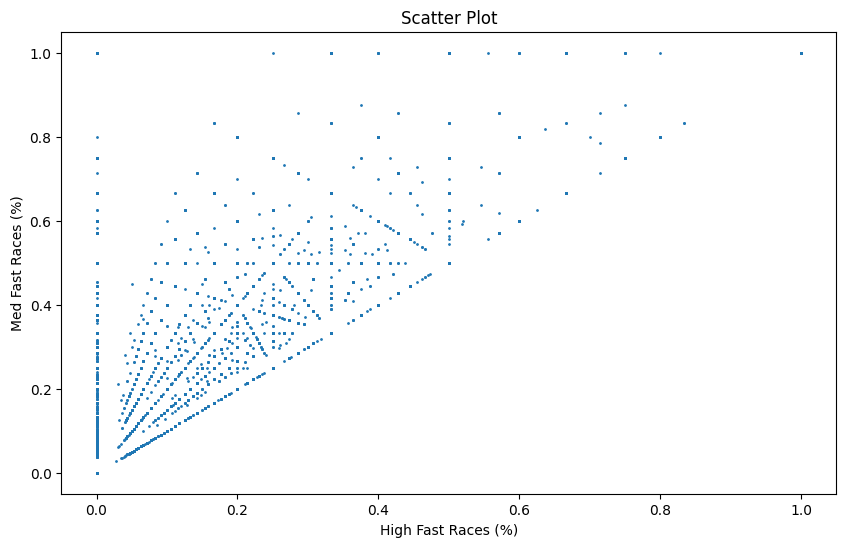

In [46]:
plt.figure(figsize = (10, 6))
plt.scatter(grouped_df['High Fast Races (%)'],
            grouped_df['Low Fast Races (%)'],
            marker = 'o',
            s = 1)
plt.xlabel('High Fast Races (%)')
plt.ylabel('Med Fast Races (%)')
plt.title('Scatter Plot');

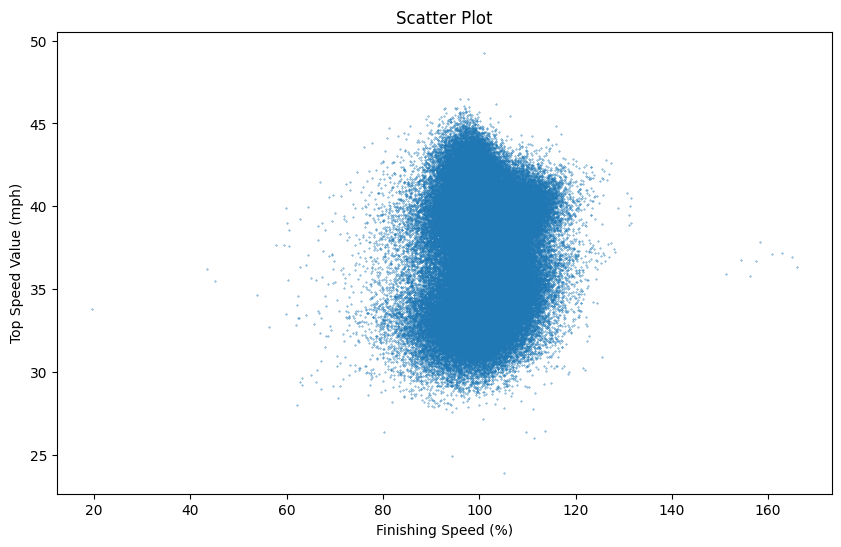

In [94]:
plt.figure(figsize = (10, 6))
plt.scatter(cleaned_df['Finishing Speed (%)'],
            cleaned_df['Top Speed Value (mph)'],
            marker = 'o',
            s = 0.1)
plt.xlabel('Finishing Speed (%)')
plt.ylabel('Top Speed Value (mph)')
plt.title('Scatter Plot');

In [75]:
mean = cleaned_df['Finishing Speed (%)'].mean()
std = cleaned_df['Finishing Speed (%)'].std()
amp = 700 * (2 * np.pi * std ** 2)

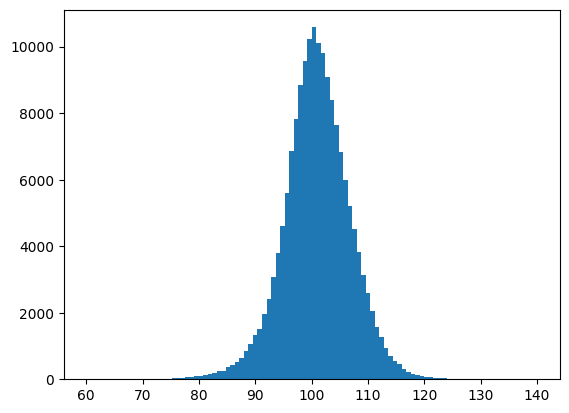

In [83]:
n, bins, patches = plt.hist(cleaned_df['Finishing Speed (%)'], label = 'Finishing Speed (%)' , bins = 100, cumulative = False, range = [60, 140])

In [87]:
x = np.linspace(80, 140, 1000)
y = n

def gauss(x, amp, mu, sigma):
    return amp * np.exp(- ((x - mu) ** 2) / (2 * sigma ** 2))

popt, pcov = curve_fit(gauss, x, y)

ValueError: operands could not be broadcast together with shapes (1000,) (100,) 

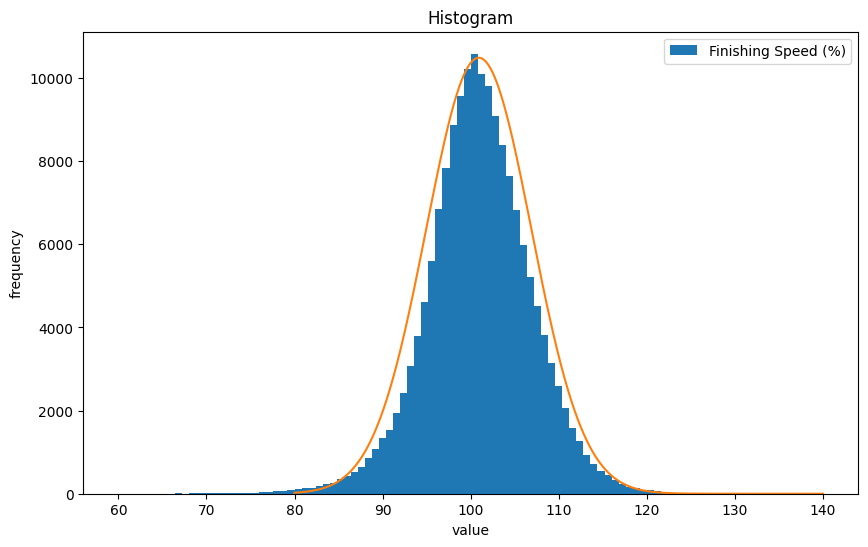

In [76]:
plt.figure(figsize = (10, 6))
plt.hist(cleaned_df['Finishing Speed (%)'], label = 'Finishing Speed (%)' , bins = 100, cumulative = False, range = [60, 140])
plt.plot(x_ticks, amp * sp.stats.norm.pdf(x_ticks, loc = mean, scale = std))
plt.legend(loc = 0)
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('Histogram');